In [17]:
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from scipy.stats import pearsonr
import qsar_utils as qu  # Assurez-vous que les fonctions nécessaires sont dans ce module
import pickle
import ast
import numpy as np
from sklearn.neighbors import NearestNeighbors
from plotnine import *

In [10]:
df_final = pd.read_csv("RFR_models/evaluation_finale_temp.csv")
df_final["num_model"] = df_final.index
def gglineplot(df, x, y, df_best , title, xlabel, ylabel):
    """
    Fonction pour tracer les performances des modèles sous forme de scatter plot
    On utiliser plotnine pour sa simplicité d'édition des graphiques (ajout des textes)
    """
    plot = (
        ggplot(data = df, mapping = aes(x = x, y = y)) 
        + geom_point(size = 3) 
        + geom_line(size = 1) 
        # + geom_errorbar(aes(ymin = df[y] - df[y+"_sd"], ymax = df[y] + df[y+"_sd"]), width = 0.2)
        + geom_text(aes(label = "num_model"), data = df_best, nudge_y = 0.001, color = "red", size = 16)
        + theme_bw()
        + xlab(xlabel)
        + ylab(ylabel)
        + ggtitle(title)
        + theme(axis_text = element_text(size = 14), 
                axis_title = element_text(size = 14),
                plot_title = element_text(size = 16),
                figure_size=(10,6))
    )
    return plot

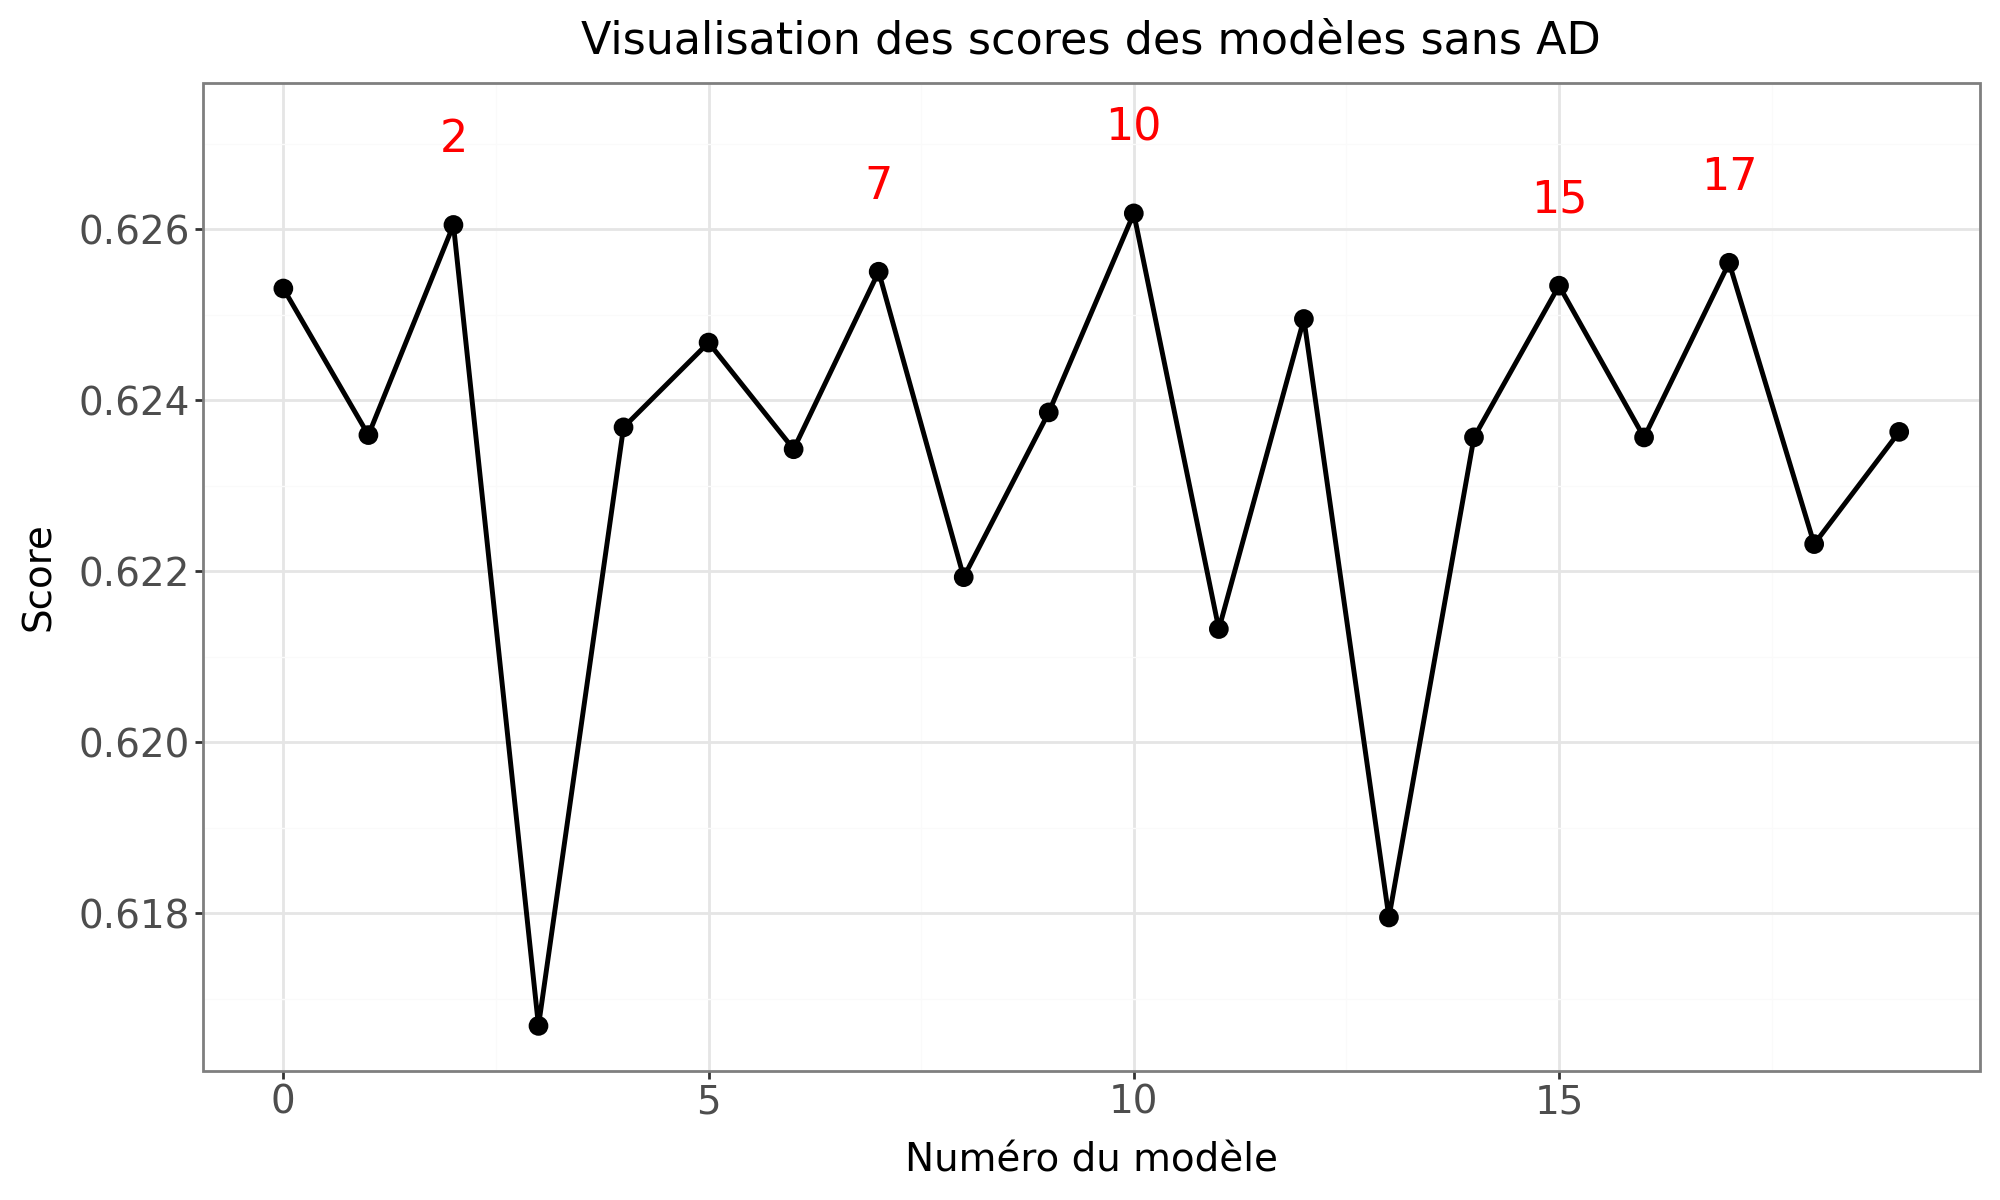

In [11]:
df_best = df_final.nlargest(5, "no_AD").copy()
p = gglineplot(df_final, "num_model", "no_AD", df_best, 
               "Visualisation des scores des modèles sans AD", "Numéro du modèle", "Score")
p

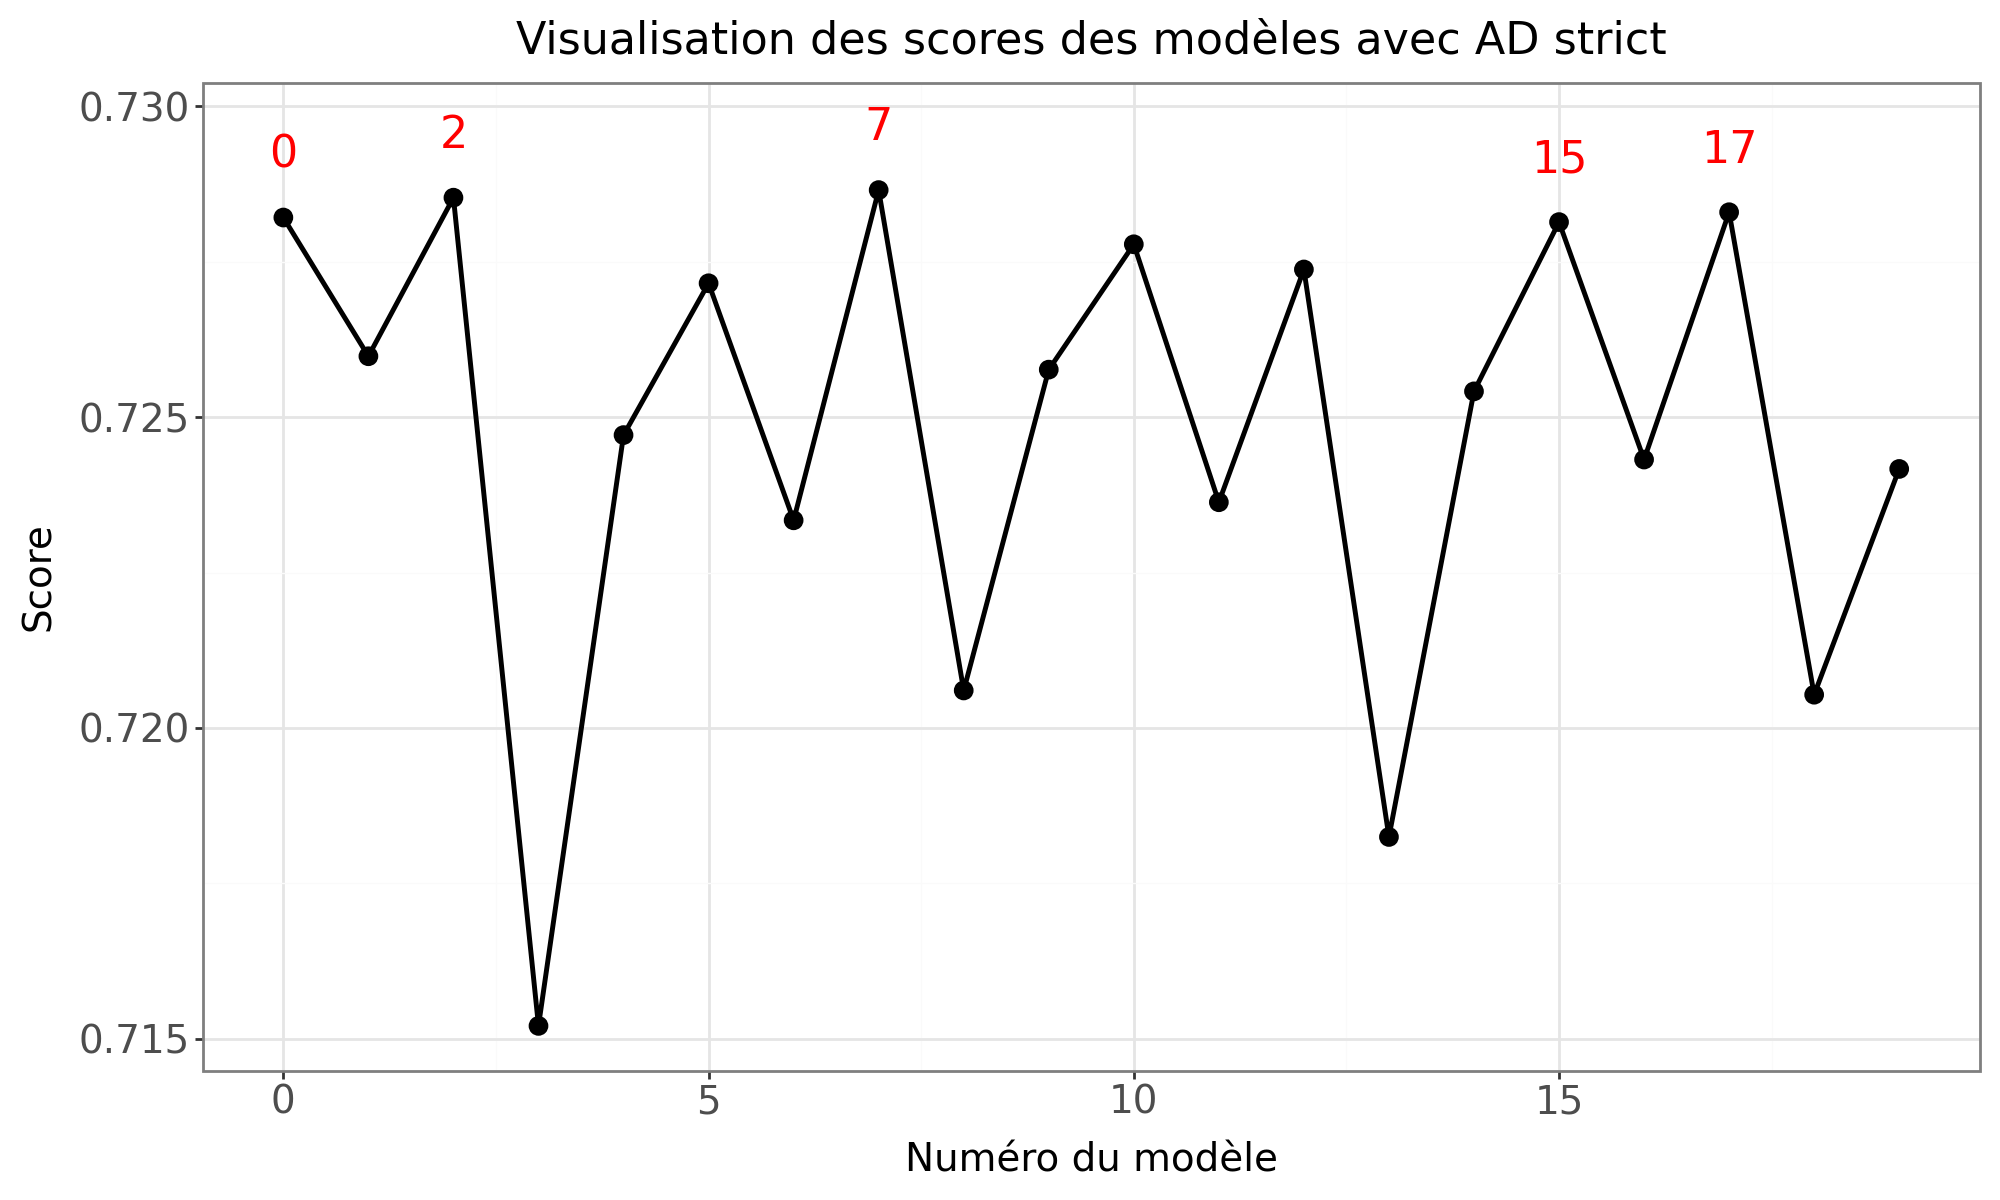

In [12]:
df_best = df_final.nlargest(5, "strict").copy()
p = gglineplot(df_final, "num_model", "strict", df_best, 
               "Visualisation des scores des modèles avec AD strict", "Numéro du modèle", "Score")
p

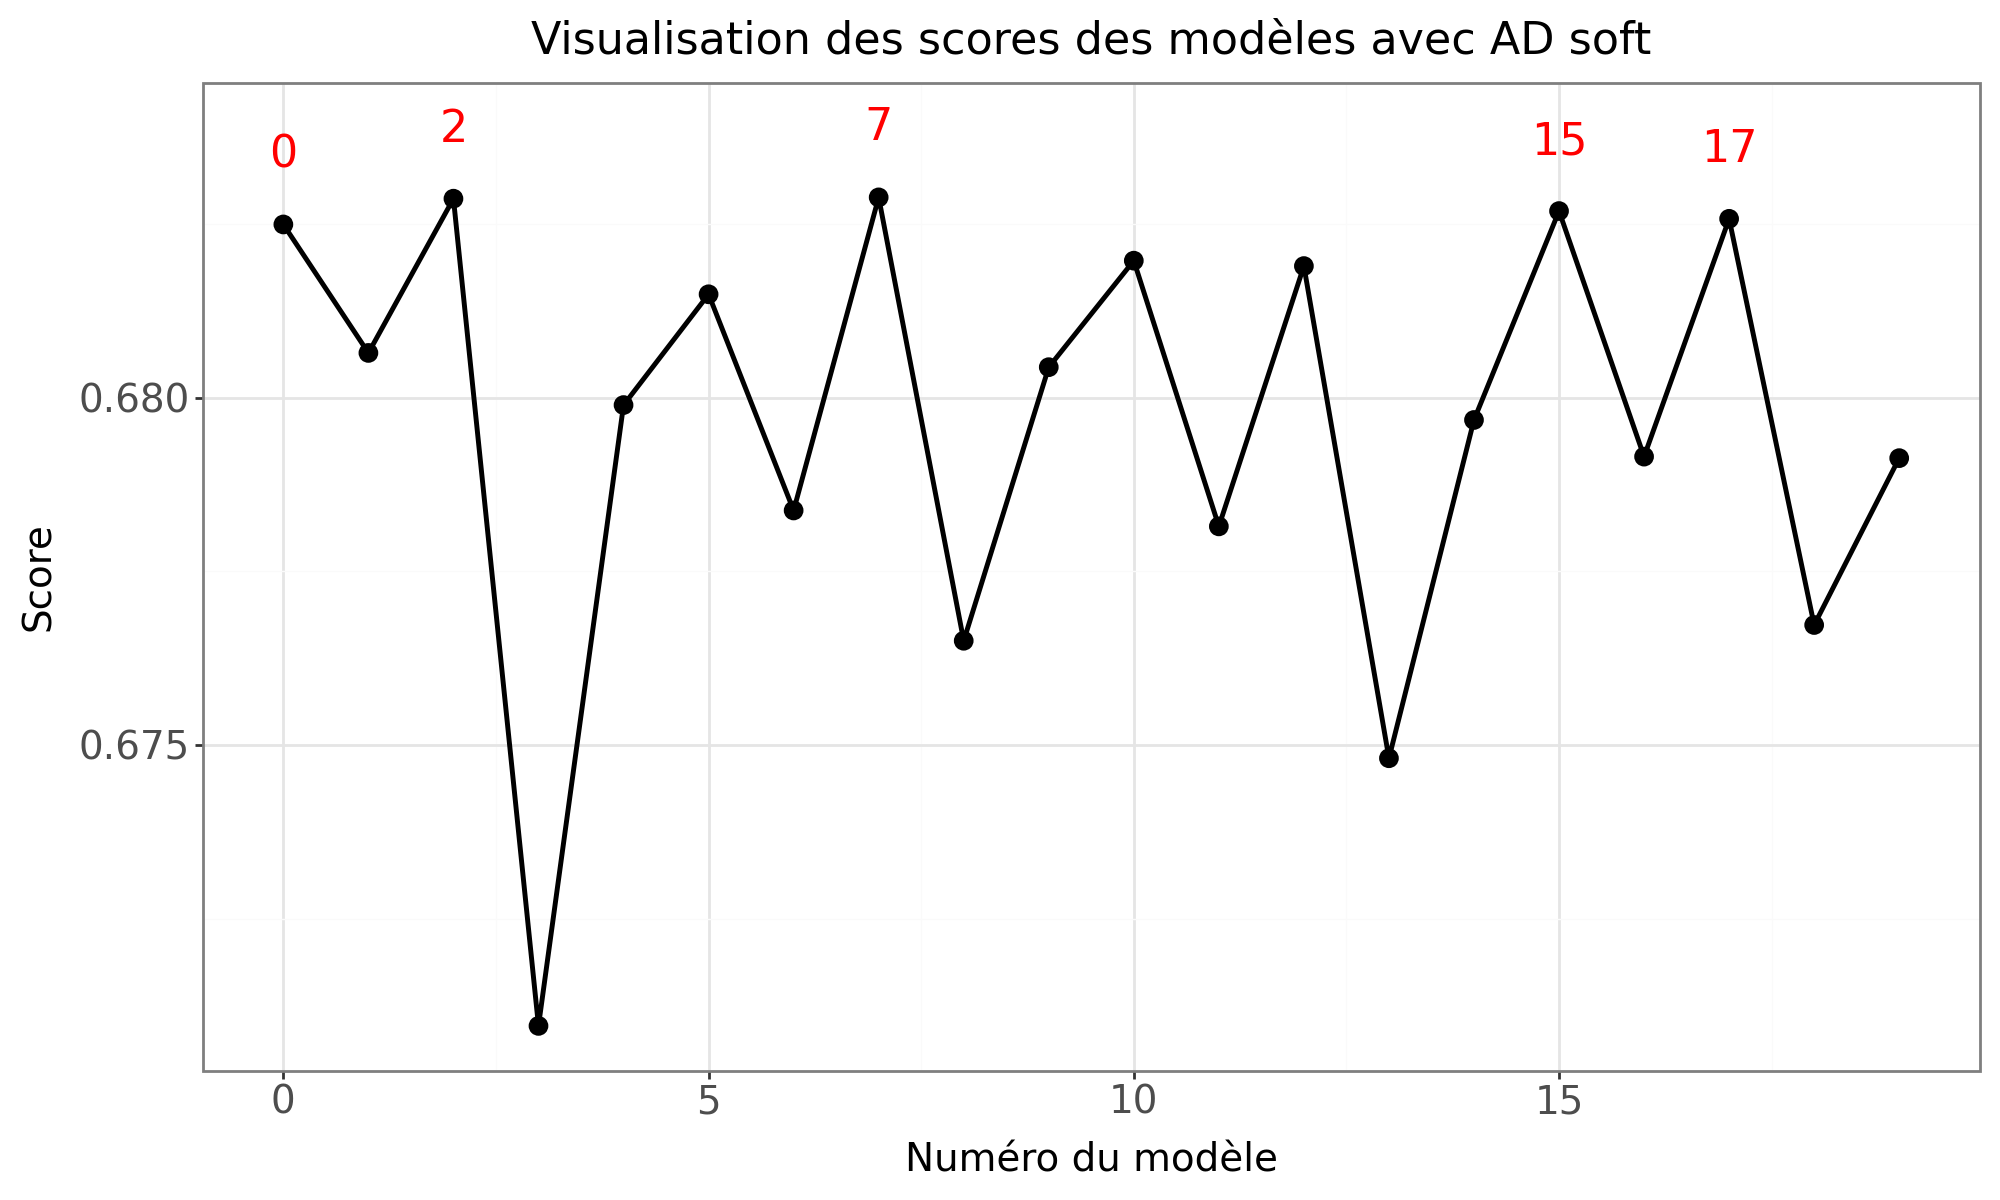

In [13]:
df_best = df_final.nlargest(5, "soft").copy()
p = gglineplot(df_final, "num_model", "soft", df_best, 
               "Visualisation des scores des modèles avec AD soft", "Numéro du modèle", "Score")
p

In [ ]:
df_norm_train = pd.read_csv("/home/mf210376/home/projet_ia/data/qsar_fish_toxicity_norm_train.csv")
df_norm_train_LC50 = df_norm_train["LC50"]
df_norm_train = df_norm_train.drop(columns=["LC50"])
df_norm_test = pd.read_csv("/home/mf210376/home/projet_ia/data/qsar_fish_toxicity_norm_test.csv")
df_norm_test_LC50 = df_norm_test["LC50"]
df_norm_test = df_norm_test.drop(columns=["LC50"])
#on prend le modèle 3, index 2
rFR = RandomForestRegressor(max_depth=39, min_samples_leaf=2, min_samples_split=4,n_estimators=7380)
print("Entrainement du modèle")
rFR.fit(df_norm_train, df_norm_train_LC50)
print("Prédiction du modèle")
predicted = rFR.predict(df_norm_test)

Entrainement du modèle
Prédiction du modèle


In [23]:
dict_results = qu.evaluate_RF(X_train_outer=df_norm_train,
                               X_test_outer=df_norm_test,
                               y_test_outer=df_norm_test_LC50,
                               y_pred_outer=predicted,
                               knn = NearestNeighbors(n_neighbors=6, metric='euclidean'),
                               threshold_strict=0.13,
                               threshold_soft=0.2)

for keys, values in dict_results.items():
    print(f"Results for {keys} : Qsquared = {values[0]:.3f}, molecules inside AD = {values[1]}, molecules out of AD = {values[2]}")

Results for no_AD : Qsquared = 0.590, molecules inside AD = 182, molecules out of AD = 0
Results for strict : Qsquared = 0.683, molecules inside AD = 107, molecules out of AD = 75
Results for soft : Qsquared = 0.600, molecules inside AD = 152, molecules out of AD = 30


In [24]:
y_pred_strict, y_test_strict, _ = qu.apply_AD(X_train = df_norm_train,
                                            X_test = df_norm_test,
                                            y_test = df_norm_test_LC50,
                                            y_pred_test = predicted,
                                            knn = NearestNeighbors(n_neighbors=6, metric='euclidean'), threshold=0.13)

y_pred_soft, y_test_soft, _ = qu.apply_AD(X_train = df_norm_train,
                                        X_test = df_norm_test,
                                        y_test = df_norm_test_LC50,
                                        y_pred_test = predicted,
                                        knn = NearestNeighbors(n_neighbors=6, metric='euclidean'), threshold=0.20)



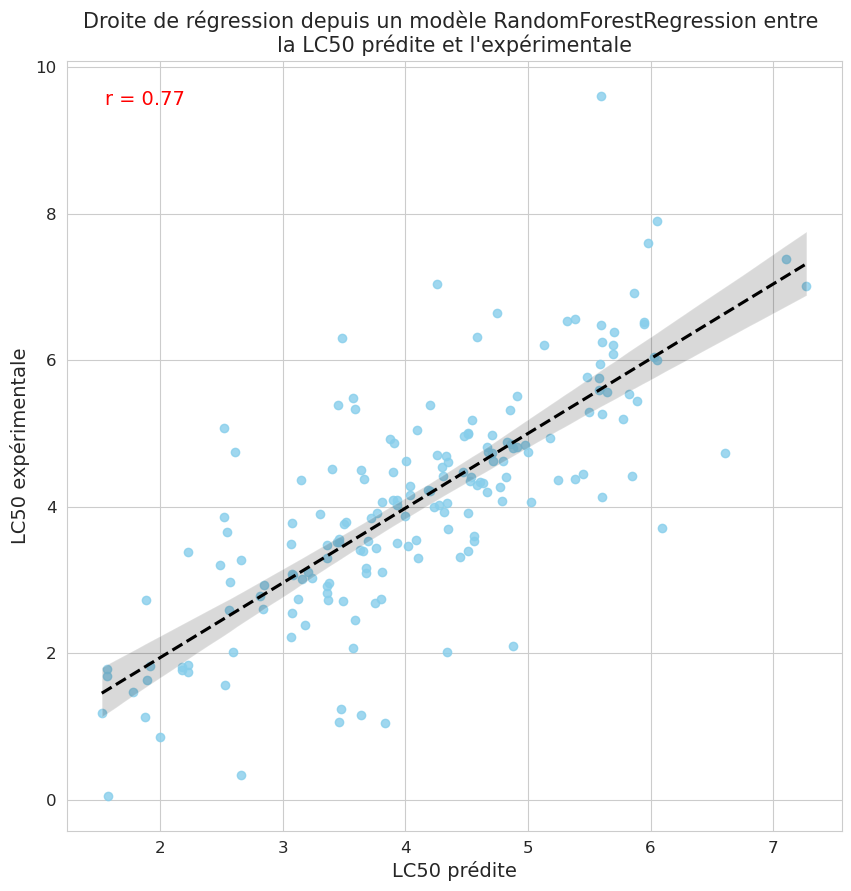

In [25]:
corr_coef = pearsonr(df_norm_test_LC50, predicted)[0]
qu.scatter_QSAR(x_data=predicted, 
                corr_coef=corr_coef,
                y_data = df_norm_test_LC50, 
                model_type="RandomForestRegression")

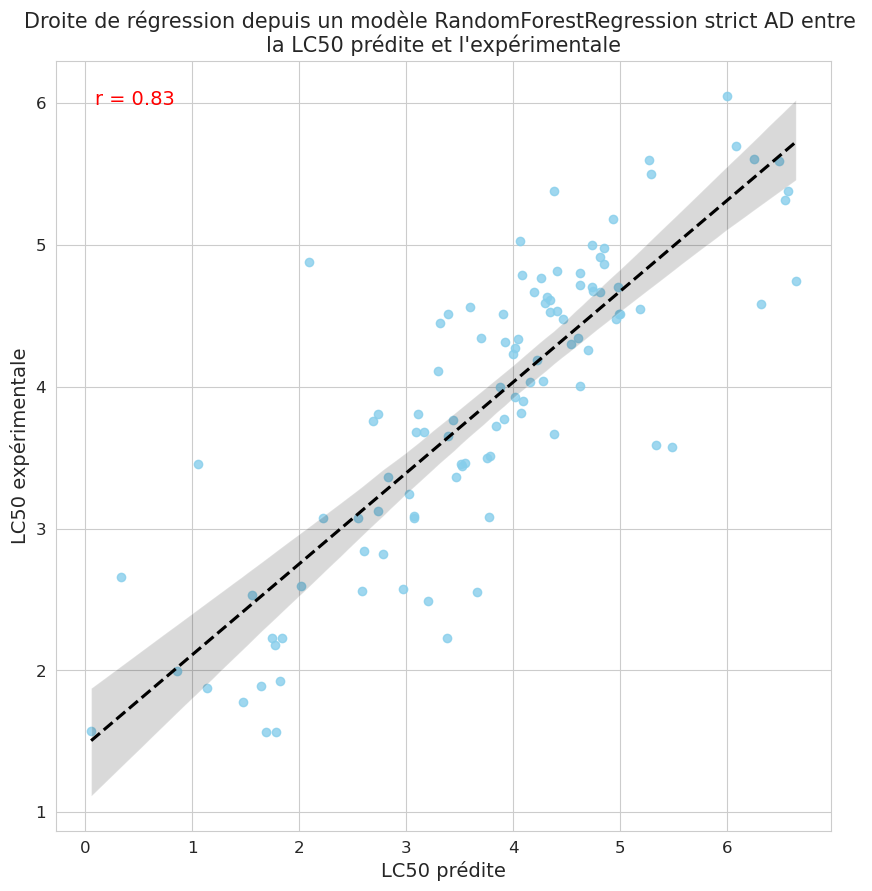

In [26]:
corr_coef = pearsonr(y_test_strict, y_pred_strict)[0]
qu.scatter_QSAR(x_data=y_pred_strict, 
                corr_coef=corr_coef,
                y_data = y_test_strict, 
                model_type="RandomForestRegression strict AD")

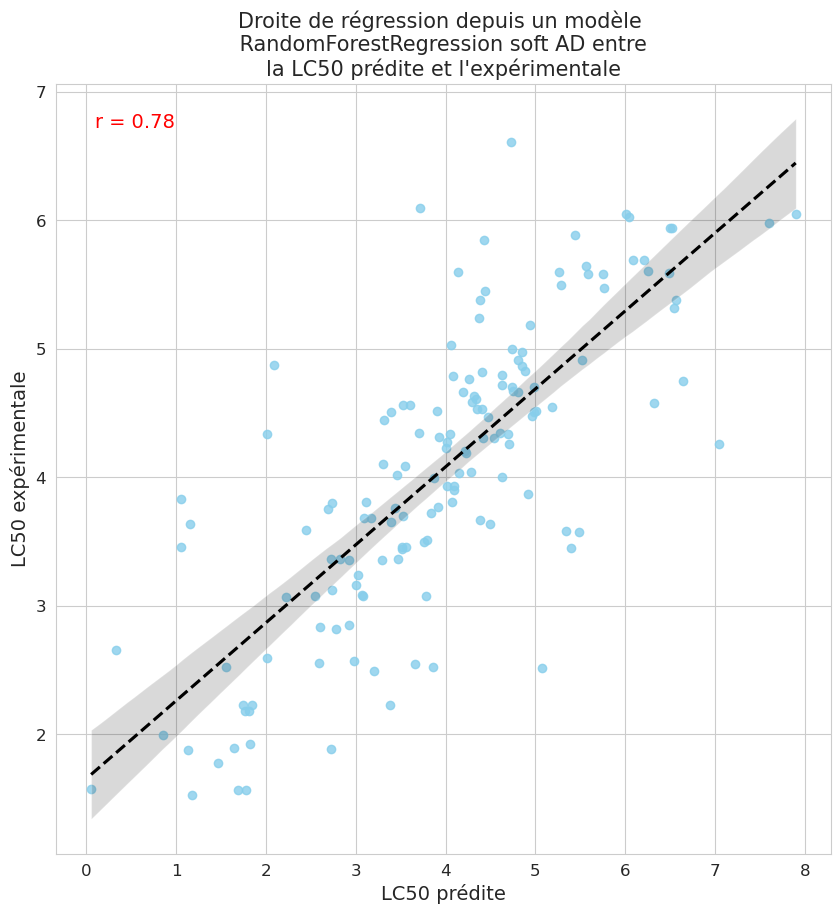

In [31]:
cor_coeff = pearsonr(y_test_soft, y_pred_soft)[0]
qu.scatter_QSAR(x_data=y_pred_soft, 
                corr_coef=cor_coeff,
                y_data = y_test_soft, 
                model_type="\n RandomForestRegression soft AD")